# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/ood_cifar10_svhn_new")

In [ ]:
get_any(results).config

_config(seed=4699, experiment_data_config=_experimentDataConfig(id_dataset_name='CIFAR-10', id_repetitions=1, initial_training_set_size=100, validation_set_size=4000, validation_split_random_state=0, evaluation_set_size=4000, add_dataset_noise=False, ood_dataset_config=_oodDatasetConfig(ood_dataset_name='SVHN', ood_repetitions=1, ood_exposure=True)), acquisition_size=2000, max_training_set=15000, max_training_epochs=300, num_pool_samples=64, num_validation_samples=20, num_training_samples=1, device='cuda', acquisition_function='batchbald_redux.acquisition_functions.BALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_trainer_factory='batchbald_redux.resnet_models.Cifar10ModelTrainer', temperature=0.0)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,38,1632524937
1,36,1632519895
2,59,1632569929
3,47,1632543846
4,28,1632497991
5,9,1632467262
6,45,1632541130
7,34,1632516761
8,22,1632492827
9,13,1632468269


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

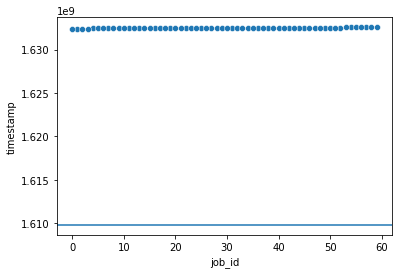

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd.axhline(y=790000 + 1.609e9)
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(60, 60)

```
configs = [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.bald,
                acquisition_size=acquisition_size,
                num_pool_samples=num_pool_samples,
            )
            for seed in range(5)
            for acquisition_size in [5, 10, 20, 50]
            for num_pool_samples in [10, 20, 50, 100]
        ] + [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.random,
                acquisition_size=5,
                num_pool_samples=20,
            )
            for seed in range(20)
        ]
```

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    config = result.config
    acquisition_size = config.acquisition_size
    
    dataset_combo = f"{config.experiment_data_config.id_dataset_name} (iD) vs {config.experiment_data_config.ood_dataset_config.ood_dataset_name} (ooD)"
    
    acquisition_function = config.acquisition_function
    if acquisition_function.startswith("batchbald_redux.acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    elif acquisition_function.startswith("batchbald_redux.baseline_acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.baseline_acquisition_functions.") :]
        
    num_pool_samples = config.num_pool_samples
    
    seed = config.seed
    
    ood_exposure = config.experiment_data_config.ood_dataset_config.ood_exposure

    if acquisition_function == "random":
        acquisition_sizes = [5, 10, 20, 50]
    else:
        acquisition_sizes = [acquisition_size]
        
    if acquisition_function == "random":
        num_pool_samples = [10, 20, 50, 100]
    else:
        num_pool_samples = [num_pool_samples]
        
    for nps in num_pool_samples:
        for acquisition_size in acquisition_sizes:
            initial_set_size = len(result.initial_training_set_indices)

            if (
                initial_set_size
                + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                * config.acquisition_size
                < 99
            ):
                print(len(result.active_learning_steps), file)
                continue

            num_acquired_ood_samples = 0
            for i, step in enumerate(result.active_learning_steps):
                if not hasattr(step, "evaluation_metrics"):
                    break
                training_set_size = initial_set_size + i * config.acquisition_size
                accuracy = step.evaluation_metrics.accuracy
                nll = step.evaluation_metrics.crossentropy
                
                active_learning_acquisitions = i * config.acquisition_size
                total_acquisitions = initial_set_size + active_learning_acquisitions
                accuracy = step.evaluation_metrics.accuracy

                experiment_data.append(
                    dict(
                        dataset_combo=dataset_combo,
                        acquisition_function=acquisition_function,
                        acquisition_size=acquisition_size,
                        num_pool_samples=nps,
                        training_set_size=training_set_size,
                        accuracy=accuracy,
                        nll=nll,
                        seed=seed,
                        ood_exposure=ood_exposure,
                        num_acquired_ood_samples=num_acquired_ood_samples,
                        active_learning_acquisitions=active_learning_acquisitions,
                        actual_training_set_size=total_acquisitions-num_acquired_ood_samples,
                        acquired_ood_sample_ratio=num_acquired_ood_samples/total_acquisitions if total_acquisitions > 0 else 0

                    )
                )
                
                if hasattr(step, "acquisition"):
                    for label in step.acquisition.labels:
                        if not ood_exposure:
                            if label == -1:
                                num_acquired_ood_samples+=1
                        else:
                            if all(t < 0.5 for t in label):
                                num_acquired_ood_samples+=1
                elif i != len(result.active_learning_steps) - 1:
                    raise Exception("'acquisition' not found in step!")

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,dataset_combo,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,nll,seed,ood_exposure,num_acquired_ood_samples,active_learning_acquisitions,actual_training_set_size,acquired_ood_sample_ratio
0,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,100,0.2656,4.742973,4699,True,0,0,100,0.000000
1,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,2100,0.4045,3.096672,4699,True,1724,2000,376,0.820952
2,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,4100,0.6538,1.821332,4699,True,1724,4000,2376,0.420488
3,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,6100,0.7562,1.165191,4699,True,1731,6000,4369,0.283770
4,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,8100,0.8170,0.849882,4699,True,1736,8000,6364,0.214321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,14100,0.7614,1.333038,4684,False,10189,14000,3911,0.722624
626,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,16100,0.7607,1.310755,4684,False,11894,16000,4206,0.738758
627,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,18100,0.7632,1.321151,4684,False,13478,18000,4622,0.744641
628,CIFAR-10 (iD) vs SVHN (ooD),BALD,2000,64,20100,0.7963,1.083778,4684,False,14923,20000,5177,0.742438


In [ ]:
df.acquisition_size.unique()

array([2000])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 100").groupby(["dataset_combo", "acquisition_size", "ood_exposure"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

dataset_combo                acquisition_size  ood_exposure  acquisition_function
CIFAR-10 (iD) vs SVHN (ooD)  2000              False         BALD                    5
                                                             EPIG                    5
                                                             EvalBALD                5
                                               True          BALD                    5
                                                             EPIG                    5
                                                             EvalBALD                5
SVHN (iD) vs CIFAR-10 (ooD)  2000              False         BALD                    5
                                                             EPIG                    5
                                                             EvalBALD                5
                                               True          BALD                    5
                                                

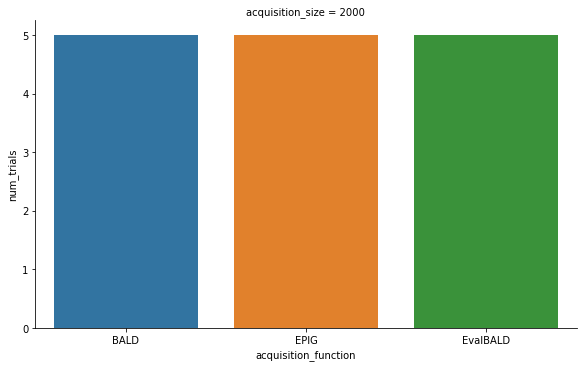

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

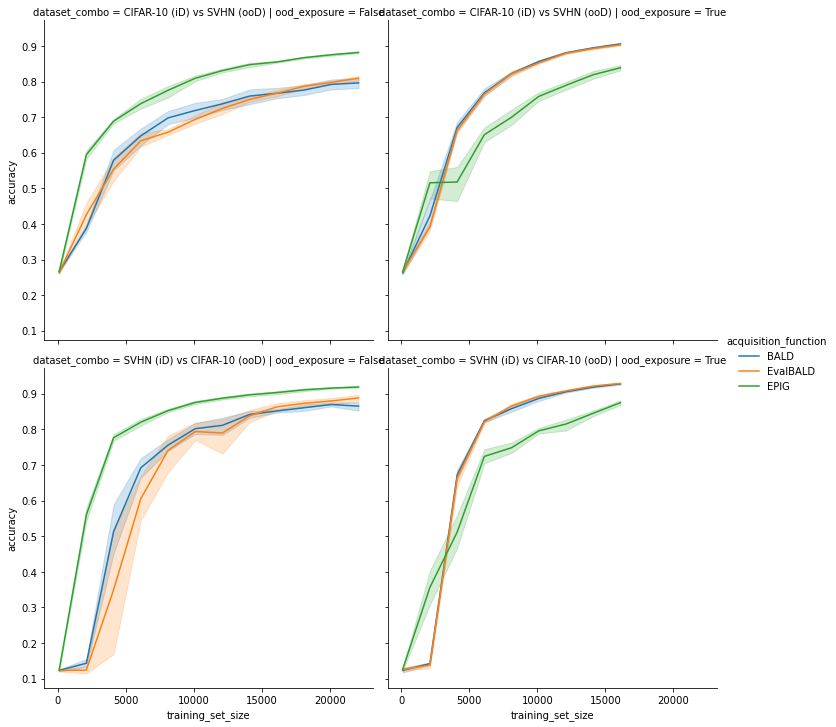

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    row="dataset_combo",
    col="ood_exposure",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

# for ax in grd.axes:
#     for x in ax:
#         x.set_xlim(0,15000)
    
grd.fig.patch.set_alpha(1)

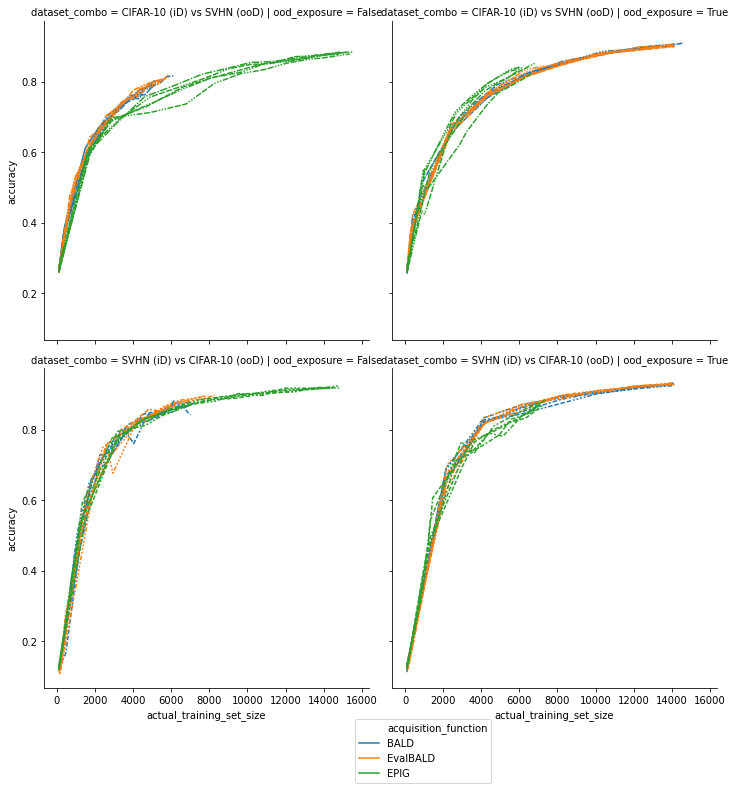

In [ ]:
grd = sns.relplot(
    x="actual_training_set_size",
    y="accuracy",
    row="dataset_combo",
    col="ood_exposure",
    hue="acquisition_function",
    style="seed",
    data=df,
    kind="line",
    height=5,
)

# for ax in grd.axes:
#     for x in ax:
#         x.set_xlim(0,15000)
    
grd.fig.patch.set_alpha(1)
grd.fig.legend(*list(zip(*list(zip(*xx.get_legend_handles_labels()))[:4])), loc="lower center", bbox_to_anchor=(0.5, -0.1))
grd.legend.remove()

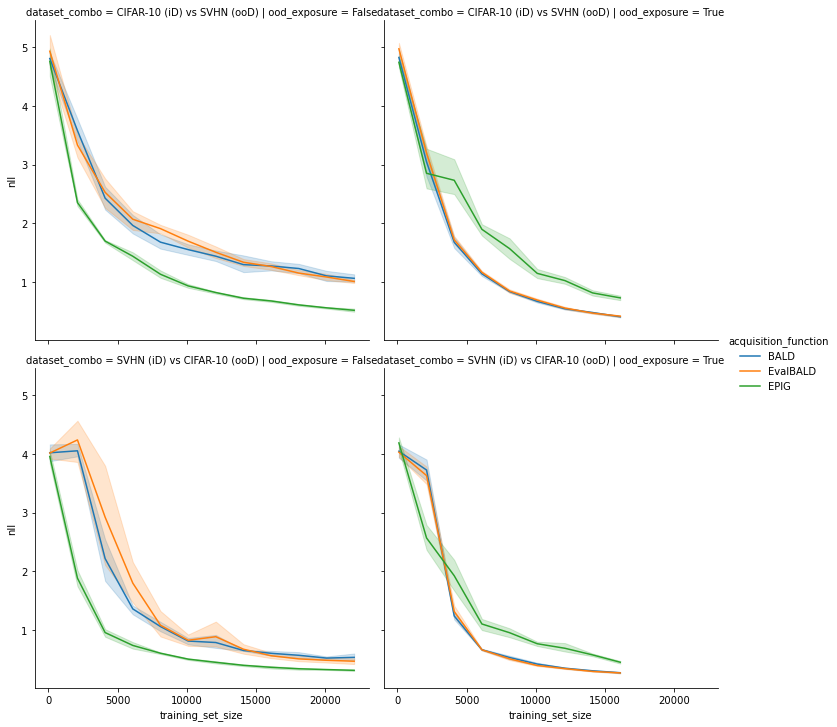

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="nll",
    row="dataset_combo",
    col="ood_exposure",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

# for ax in grd.axes:
#     for x in ax:
#         x.set_xlim(0,15000)
    
grd.fig.patch.set_alpha(1)

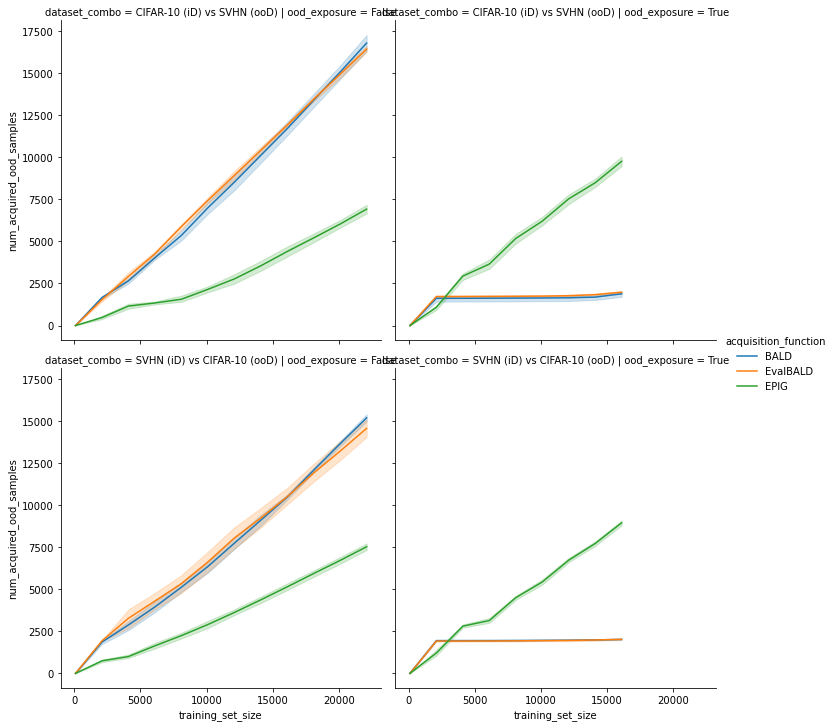

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="num_acquired_ood_samples",
    row="dataset_combo",
    col="ood_exposure",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

# for ax in grd.axes:
#     for x in ax:
#         x.set_xlim(40,10000)
    
grd.fig.patch.set_alpha(1)

In [ ]:
nan=float("nan")
scores = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
len(scores)

1013

In [ ]:
labels=[4, 2, 6, 1, 2, 9, 2, 1, 9, 9, 1, 7, 5, 5, 9, 4, 3, 1, 6, 2, 4, 2, 7, 1, 0, 1, 8, 5, 2, 0, 2, 7, 0, 2, 0, 8, 3, 9, 3, 2, 7, 3, 3, 4, 9, 1, 9, 7, 0, 0, 5, 0, 9, 9, 8, 7, 5, 6, 4, 9, 4, 9, 4, 8, 3, 5, 1, 2, 6, 5, 3, 1, 7, 1, 0, 4, 7, 9, 8, 2, 9, 5, 1, 8, 7, 3, 2, 2, 6, 1, 5, 2, 3, 1, 9, 0, 9, 8, 9, 6, 3, 5, 7, 2, 0, 9, 5, 7, 8, 4, 0, 3, 7, 2, 9, 0, 2, 9, 9, 7, 6, 5, 5, 4, 4, 0, 8, 2, 4, 8, 4, 8, 0, 2, 8, 4, 6, 1, 3, 2, 1, 9, 4, 7, 3, 0, 7, 2, 1, 5, 9, 2, 0, 2, 0, 1, 4, 7, 6, 3, 5, 4, 5, 1, 0, 9, 0, 9, 1, 7, 6, 9, 2, 9, 8, 0, 7, 6, 1, 7, 6, 2, 7, 4, 1, 2, 0, 5, 6, 0, 7, 3, 2, 7, 6, 4, 6, 0, 5, 6, 4, 6, 1, 9, 1, 9, 9, 5, 2, 5, 0, 2, 6, 9, 4, 1, 0, 5, 5, 2, 4, 1, 2, 7, 0, 0, 1, 7, 6, 5, 4, 3, 2, 2, 5, 2, 3, 5, 1, 3, 4, 8, 3, 5, 8, 8, 4, 8, 3, 3, 4, 7, 5, 4, 8, 4, 5, 4, 0, 8, 6, 7, 7, 4, 7, 1, 5, 6, 9, 8, 5, 3, 1, 6, 7, 2, 9, 8, 8, 6, 5, 6, 4, 6, 3, 7, 5, 2, 0, 1, 7, 6, 2, 3, 9, 3, 0, 2, 5, 4, 5, 5, 4, 9, 5, 9, 5, 9, 2, 5, 4, 4, 7, 1, 0, 4, 6, 2, 3, 6, 2, 8, 8, 9, 0, 7, 0, 0, 0, 5, 6, 4, 6, 0, 3, 8, 7, 1, 7, 3, 2, 9, 4, 9, 3, 3, 4, 9, 7, 0, 6, 2, 0, 9, 6, 3, 0, 6, 1, 6, 0, 9, 2, 0, 2, 5, 8, 4, 1, 3, 3, 7, 7, 9, 5, 5, 7, 1, 1, 0, 3, 9, 7, 6, 7, 1, 6, 0, 7, 5, 9, 0, 8, 5, 5, 3, 2, 3, 8, 3, 9, 1, 3, 7, 3, 4, 7, 4, 1, 2, 6, 1, 2, 9, 0, 5, 0, 8, 9, 8, 8, 9, 7, 1, 1, 9, 9, 7, 0, 6, 8, 8, 2, 0, 8, 9, 3, 0, 1, 2, 7, 6, 9, 0, 9, 0, 6, 7, 4, 4, 2, 8, 5, 3, 9, 1, 2, 9, 9, 4, 4, 7, 0, 1, 9, 1, 1, 2, 3, 1, 4, 3, 4, 4, 6, 3, 3, 0, 8, 4, 4, 1, 9, 2, 5, 3, 2, 4, 2, 3, 9, 0, 9, 2, 7, 7, 3, 6, 8, 8, 0, 4, 8, 0, 6, 3, 6, 9, 3, 2, 4, 4, 9, 3, 3, 3, 7, 4, 1, 7, 2, 2, 1, 3, 7, 3, 0, 3, 5, 6, 5, 8, 5, 7, 3, 7, 6, 5, 3, 0, 4, 9, 1, 2, 0, 7, 6, 4, 1, 7, 2, 8, 5, 1, 7, 4, 6, 1, 4, 8, 4, 9, 4, 1, 1, 0, 0, 7, 1, 9, 7, 0, 9, 3, 4, 1, 4, 9, 7, 0, 7, 1, 4, 1, 6, 7, 2, 7, 2, 3, 0, 1, 6, 9, 0, 4, 4, 1, 8, 7, 0, 3, 0, 1, 7, 2, 4, 2, 4, 1, 8, 5, 8, 3, 6, 8, 2, 9, 7, 8, 8, 4, 0, 1, 7, 8, 0, 2, 4, 7, 9, 2, 2, 9, 5, 4, 5, 6, 6, 0, 1, 6, 2, 8, 5, 2, 8, 1, 3, 6, 2, 4, 2, 7, 9, 9, 3, 4, 9, 6, 6, 1, 5, 8, 3, 8, 7, 9, 9, 5, 3, 0, 8, 2, 9, 8, 6, 6, 1, 2, 4, 4, 9, 7, 7, 2, 4, 4, 8, 8, 8, 4, 5, 9, 8, 8, 5, 0, 1, 6, 8, 9, 3, 2, 1, 3, 1, 6, 3, 1, 2, 0, 3, 4, 4, 7, 5, 3, 0, 4, 1, 6, 4, 2, 7, 7, 8, 2, 2, 1, 7, 2, 2, 6, 7, 2, 9, 9, 1, 9, 8, 1, 5, 2, 4, 9, 1, 3, 8, 4, 8, 8, 9, 5, 5, 9, 1, 7, 9, 4, 2, 2, 0, 5, 5, 8, 1, 0, 1, 0, 4, 0, 0, 2, 8, 3, 7, 3, 4, 3, 2, 4, 0, 6, 4, 2, 2, 4, 4, 5, 3, 4, 1, 7, 1, 0, 5, 4, 1, 1, 0, 5, 7, 1, 7, 5, 6, 6, 3, 4, 3, 6, 0, 7, 6, 2, 2, 7, 6, 6, 6, 8, 4, 2, 2, 6, 0, 8, 6, 5, 3, 8, 3, 8, 0, 5, 4, 6, 4, 4, 5, 7, 8, 6, 7, 0, 0, 9, 1, 4, 4, 1, 6, 7, 8, 6, 6, 6, 8, 8, 6, 7, 1, 2, 3, 1, 8, 0, 1, 3, 5, 3, 6, 1, 2, 4, 6, 0, 0, 2, 6, 8, 6, 3, 4, 4, 6, 3, 9, 5, 7, 7, 0, 8, 6, 7, 6, 6, 7, 8, 9, 5, 3, 5, 0, 7, 0, 3, 1, 0, 3, 2, 8, 9, 6, 6, 3, 4, 7, 1, 1, 7, 7, 2, 4, 3, 6, 4, 7, 5, 9, 1, 7, 5, 9, 5, 0, 0, 7, 6, 2, 7, 6, 1, 7, 6, 2, 2, 1, 5, 0, 4, 2, 1, 2, 0, 0, 9, 8, 6, 3, 7, 7, 9, 2, 1, 5, 1, 4, 7, 5, 8, 1, 2, 1, 4, 1, 2, 7, 4, 3, 6, 4, 4, 3, 8, 3, 2, 1, 0, 1, 5, 6, 1, 1, 8, 6, 2, 5, 5, 4, 6, 5, 6, 9, 0, 8, 5, 9, 1, 1, 6, 5, 8, 3, 2, 3, 4, 9, 4, 5, 6, 2, 6, 1, 1, 1, 0, 6, 2, 0, 1, 9, 5, 0, 3, 6, -1, 2, 2, 9, 9, 7, 7, 6, -1, 1, -1, 1, 2, 2, -1, 6, -1, 5, -1, -1, -1, 7, 3, -1, 9, 3, 1, 8, 9, 2, 9, 0, 5, 7, -1, 7, 1, 1, 0, -1, 2, 0, 9, 1, 3, 9, 0, -1, 3, 2, 9, 9, 9, 1, 0, 5, 2, 4, 7, 1, 3, 1, 0, 0, 8, 4, 0, 1, 8, 1, -1, 6, 8, 8, -1, 9, 0, 2, 0, -1, 0, 9, 9, 1, -1, 1, 1, 7, 8, 5, 7, -1, 5, -1, -1, 2, 8, 9, -1, -1, 9, 5, 3, 3, 0, 1, 5, 6, -1, 6, -1, 3, 5, 5, -1, -1, 8, 4, 5, 7, 4, -1, 3, 0, 1, 4, 3, -1, 1, 9, -1, 9, 9, 9, 4, -1, 9, 1, -1, 6, 5, 6, 9, 9, 2, -1, 8, 3, 7, 3, 2, 7, 1, 3, -1, 1, -1, 1, 5, 9, 9, 5, 1, 9, 7, 1, 0, 5, -1, 2, 5, 1, 9, 9, 7, -1, -1, 9, 7, 3, -1, 5, 2, 1, 0, 5, 9, 2, 8, 5, 5, -1, 7, 7, 1, 9, 0, 9, -1, 2, 9, 3, 9, 1, -1, 7, 2, 7, 9, 1, -1, 9, 9, 0, -1, 2, -1, 2, 7, 9, 8, 1, 1, 6, 3, -1, 8, 8, 3, 5, 9, -1, -1, 1, 7, 8, 9, 9, 6, 9, 0, -1, 4, 7, 8, 0, 0, -1, -1, 3, 5, -1, 7, -1, 0, 5, 5, 3, 6, 7, 6, -1, 5, 7, 3, 0, -1, -1, -1, -1, 1, 4, 1, 5, -1, 3, 2, 3, -1, 3, 9, -1, 2, 2, 7, 8, -1, -1, 5, 0, 0, 4, 5, 2, 9, -1, 1, 9, 0, 4, -1, 0, 3, -1, -1, -1, 6, 2, 4, 3, 4, 0, -1, 9, 4, -1, 5, 4, 6, -1, 1, 0, -1, 7, -1, 6, 9, 0, 5, -1, 3, -1, -1, 7, 9, 5, -1, 1, 7, -1, 2, 6, 8, 4, 9, -1, 0, 2, 7, 9, 9, 5, 6, 9, -1, 9, -1, 9, 6, 2, 8, -1, 1, 9, 4, -1, -1, 9, 7, 1, 4, 1, 2, 5, -1, -1, 5, -1, 6, 1, -1, -1, 4, 2, -1, 3, 6, 6, 1, -1, 1, 3, 2, -1, -1, 2, 3, -1, 9, -1, 1, 0, 4, 3, -1, -1, 9, 8, 6, 2, 5, 8, -1, 8, 5, 0, 8, 5, 7, 1, 7, 0, -1, 6, -1, -1, 9, 5, 9, 1, 5, 3, 7, -1, 1, -1, -1, -1, 1, 4, -1, 3, 5, -1, 9, 4, 4, 1, -1, 6, 7, -1, 7, 7, 2, 1, 9, 8, 4, 9, -1, 0, 7, 2, -1, -1, -1, 2, 4, 3, -1, 1, -1, 0, 1, 2, 4, -1, 2, 7, 4, 1, 6, 4, 3, -1, 3, -1, -1, 9, 1, 9, -1, -1, 3, 7, -1, 7, -1, 7, -1, 5, -1, -1, 2, -1, 3, -1, 8, -1, 4, -1, 6, 0, 9, 1, -1, 1, 8, -1, 7, 3, 9, 4, 9, 6, 2, 0, 3, 7, 0, -1, 1, 9, 1, -1, 7, -1, 4, 1, -1, 6, -1, 7, 0, -1, 0, -1, 1, -1, 2, 0, 0, -1, -1, 3, -1, 8, 6, -1, 8, 3, -1, 2, 3, 5, 0, 0, 3, 2, 5, 5, -1, 8, 2, -1, -1, 7, 9, 1, 9, -1, 1, 6, 6, -1, 9, 6, 8, -1, -1, 2, 3, 3, 0, 5, 4, -1, -1, -1, -1, -1, 5, 7, 2, 0, 0, 7, 6, 3, 0, -1, 2, -1, 7, 2, 4, -1, 5, -1, -1, -1, -1, 9, 3, 6, 1, 1, 9, 7, 1, 9, -1, 9, 6, 5, 9, 1, -1, 1, -1, -1, 4, 1, 2, -1, 0, 0, 3, -1, -1, 3, 1, 1, -1, 9, 2, -1, 8, -1, -1, 0, 9, 2, -1, 6, -1, -1, -1, 9, 0, 7, 8, 6, 7, 8, 5, 7, -1, 3, -1, 1, 0, 8, 1, -1, 9, -1, -1, -1, -1, -1, 1, 8, 4, 7, 1, 4, 2, 2, -1, 8, 9, -1, -1, 7, -1, -1, -1, 7, 9, 2, 1, 7, -1, 1, 5, 7, -1, -1, -1, -1, -1, 8, 1, -1, -1, -1, -1, 0, -1, 9, 7, 3, -1, 7, -1, 3, -1, -1, 5, 5, -1, -1, 2, 7, 6, 9, 4, 4, 0, 1, 4, -1, -1, 3, 9, -1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1, 5, 5, 1, -1, -1, 1, 9, 8, 8, -1, -1, 4, 2, 1, -1, 1, 7, 9, 7, -1, 7, -1, 9, 9, 4, 4, 5, -1, 3, -1, 9, 1, -1, 1, -1, 5, -1, 5, 1, 9, -1, -1, -1, -1, 9, 5, -1, 1, 7, -1, -1, 7, 0, 7, 2, 8, -1, -1, 3, -1, 4, 5, -1, 1, 6, -1, -1, 5, -1, -1, -1, -1, -1, 1, 7, -1, 9, -1, 2, 1, -1, -1, -1, -1, 1, 1, -1, 9, -1, 3, -1, 0, 9, 5, -1, -1, 4, -1, -1, 6, -1, 1, 1, 7, 3, 7, 1, 3, 1, 8, 3, 5, 3, 7, 9, -1, 1, -1, 8, 9, 3, 8, -1, 0, -1, -1, -1, 3, 2, 1, -1, 9, -1, 9, -1, 1, 9, 5, 0, 2, 5, 8, -1, 9, -1, 9, 7, -1, -1, 7, -1, -1, -1, 4, -1, -1, 7, 1, -1, -1, -1, -1, -1, -1, 3, 2, -1, 8, 3, -1, 5, -1, -1, -1, 4, 8, 1, -1, 9, -1, -1, 7, -1, 3, 6, 7, 5, 1, -1, 0, 7, -1, -1, 7, -1]

In [ ]:
sum(1 if label == -1 else 0 for label in labels)

301

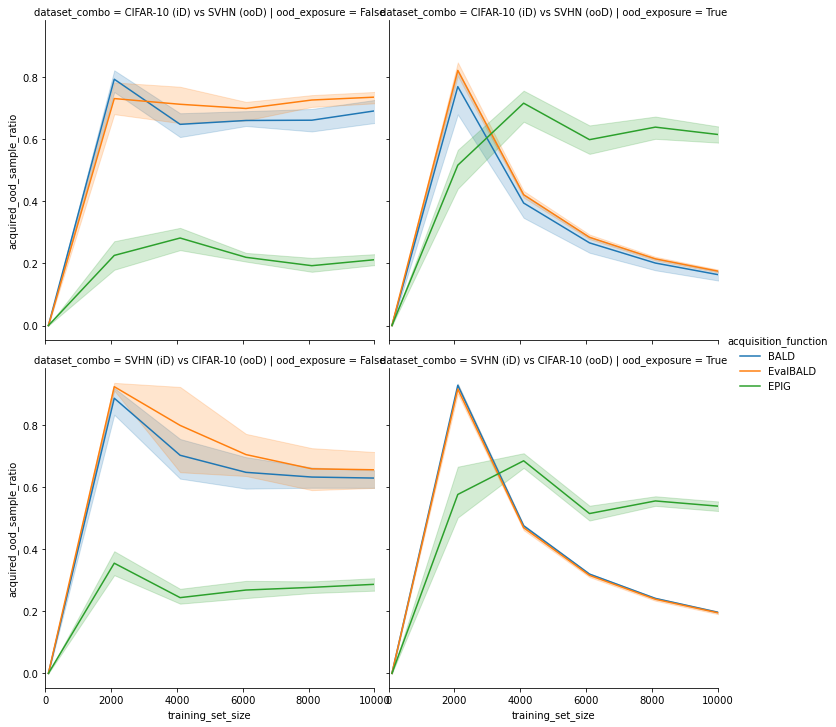

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="acquired_ood_sample_ratio",
    row="dataset_combo",
    col="ood_exposure",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

for ax in grd.axes:
    for x in ax:
        x.set_xlim(0,10000)
    
grd.fig.patch.set_alpha(1)

In [ ]:
#df.to_pickle("./plots_data/epig_vs_evalbald_bald.pkl")

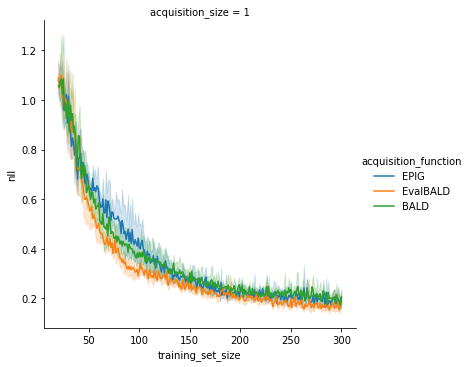

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="nll",
    col="acquisition_size",
    hue="acquisition_function",
    data=df[df.num_pool_samples==100],
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

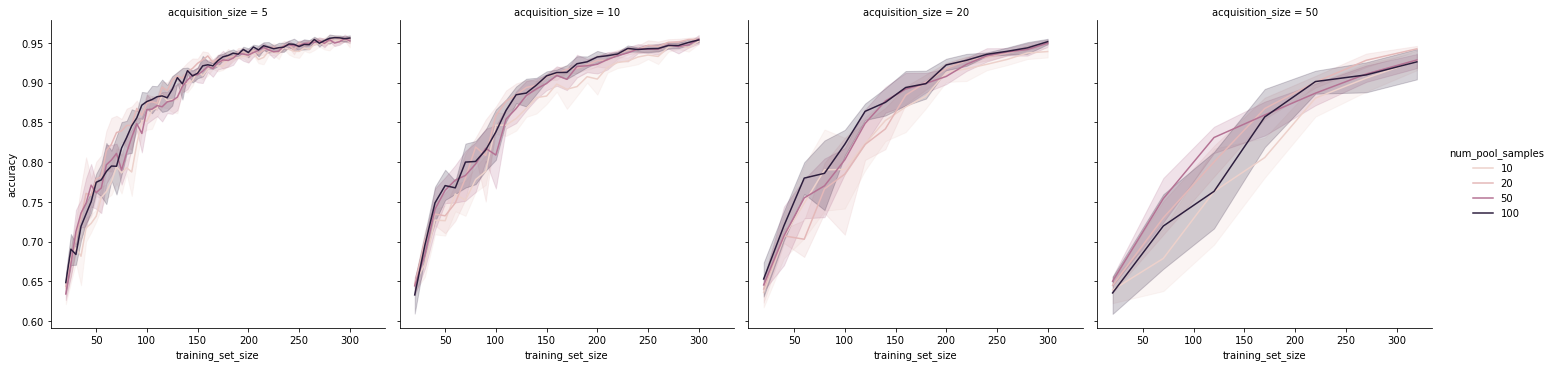

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="num_pool_samples",
    data=df[df.acquisition_function=="bald"],
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

df["max_accuracy"] = df.groupby(["seed", "acquisition_size", "acquisition_function", "num_pool_samples"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "acquisition_size", "acquisition_function", "num_pool_samples", "max_accuracy"])
df_max_accuracy

,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,max_accuracy
0,bald,20,50,20,0.6365,27,0.6365
1,bald,20,50,40,0.6420,27,0.6420
2,bald,20,50,60,0.7008,27,0.7008
3,bald,20,50,80,0.7533,27,0.7533
4,bald,20,50,100,0.7995,27,0.7995
...,...,...,...,...,...,...,...
20390,bald,10,10,210,0.9386,21,0.9386
20393,bald,10,10,240,0.9401,21,0.9401
20396,bald,10,10,270,0.9426,21,0.9426
20397,bald,10,10,280,0.9524,21,0.9524


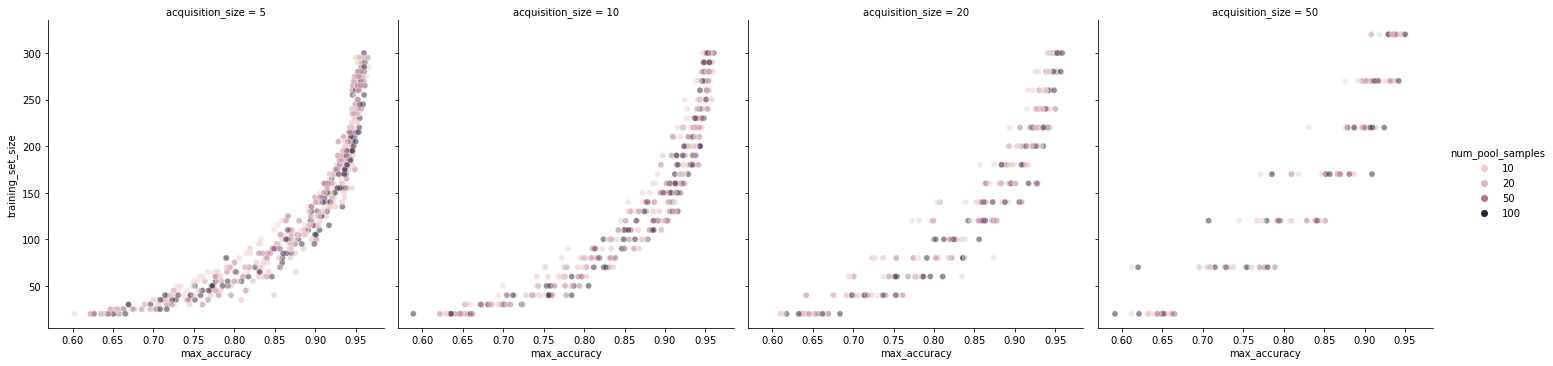

In [ ]:
grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    col="acquisition_size",
    hue="num_pool_samples",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "random")].groupby(["seed", "acquisition_size", "acquisition_function", "num_pool_samples"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function", "num_pool_samples"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                                         0.25   0.50   0.75
acquisition_size acquisition_function num_pool_samples                     
5                bald                 10                125.0  135.0  140.0
                                      20                115.0  120.0  125.0
                                      50                130.0  140.0  140.0
                                      100               125.0  125.0  130.0
10               bald                 10                140.0  160.0  210.0
                                      20                130.0  140.0  140.0
                                      50                130.0  160.0  160.0
                                      100               130.0  140.0  150.0
20               bald                 10                180.0  200.0  200.0
                                      20                180.0  200.0  200.0
                                      50                160.0  180.0  200.0
            